# Conversion Rate Analysis
The purpose of this analysis is to find out, if we were to start a campaign, which user group would most likely to return a good result.

This is a binary classification analysis, so I will go ahead and start with user data exploration, user labeling and basic visualization, then I'll use two different models to fit the data and evaluate the model with test data.

Finally I'll review the model and share my suggestions and conclusions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

## 1. Import, read and understand data

In [2]:
df=pd.read_csv('conversion_project.csv')
df

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0
...,...,...,...,...,...,...
316195,US,26,1,Ads,9,0
316196,US,27,1,Direct,6,0
316197,China,25,0,Ads,4,0
316198,US,22,0,Seo,4,0


In [3]:
df.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [4]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


Here we have an 123-year-old person which I believe should not both physically and digitally be here. So I'm going to check all the data that does not look normal to me.

In [5]:
df[df['age']>80].age

90928     123
295581    111
Name: age, dtype: int64

There are two persons older than 100 years old, which should be long gone but for some reason still hanging around. I will put them to sleep later in data cleaning process.

In [6]:
df[(df['new_user']!=1) & (df['new_user']!=0)]

,country,age,new_user,source,total_pages_visited,converted


In [7]:
df[(df['converted']!=0) & (df['converted']!=1)]

,country,age,new_user,source,total_pages_visited,converted


In [8]:
df.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

All other data seems fine. So I'll just go ahead and put the two oldies to sleep.

In [9]:
df=df[df['age']<80]
df.shape

(316198, 6)

Now I want to carry out a little bit analysis here about the converted users versus the un-converted ones. We can start from comparing the age and user status.

# 2. Data Exploration and Analysis

In [10]:
df.converted.value_counts()

converted
0    306000
1     10198
Name: count, dtype: int64

([<matplotlib.axis.XTick at 0x1440d14b550>,
 [Text(0, 0, 'not converted'), Text(1, 0, 'converted')])

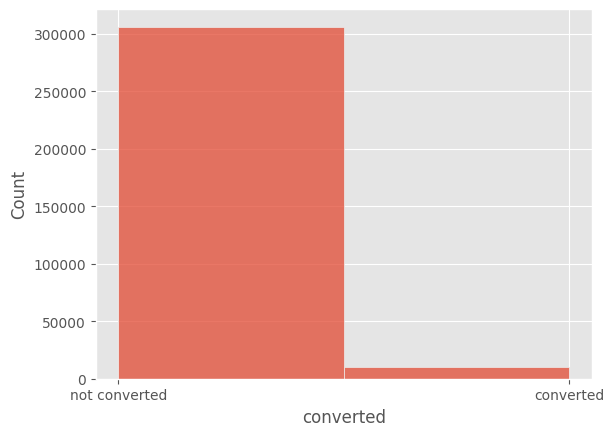

In [11]:
sns.histplot(df.converted,bins=2)
plt.xticks([0,1],['not converted','converted'])

From conversion histogram it's safe to say this is a very imbalanced dataset. I'll use SMOTE method to preprocess the data and Precision-Recall curve to evaluate models later on.

In [12]:
df.groupby(['converted']).mean(numeric_only=True)

,age,new_user,total_pages_visited
converted,,,
0,30.703961,0.698382,4.550281
1,26.529025,0.298000,14.553932


A glance at the mean shows young audience tends to be converted easier. But I'll go deeper in terms of age, nationality, source and total pages visited.

<Axes: title={'center': 'conversion rate by age'}, xlabel='age'>

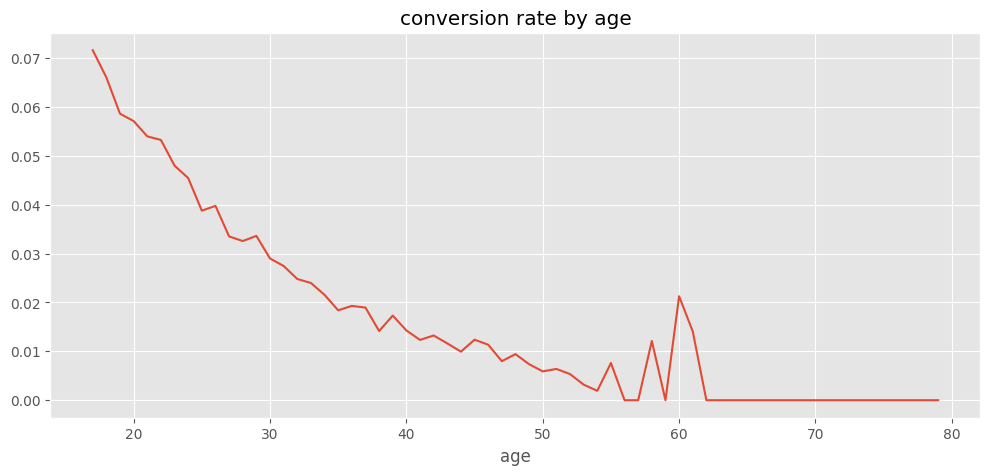

In [13]:
data_age=df.groupby('age').converted.mean(numeric_only=True)
data_age.plot(title='conversion rate by age',figsize=(12,5))

<Axes: title={'center': 'conversion rate by country'}, xlabel='country'>

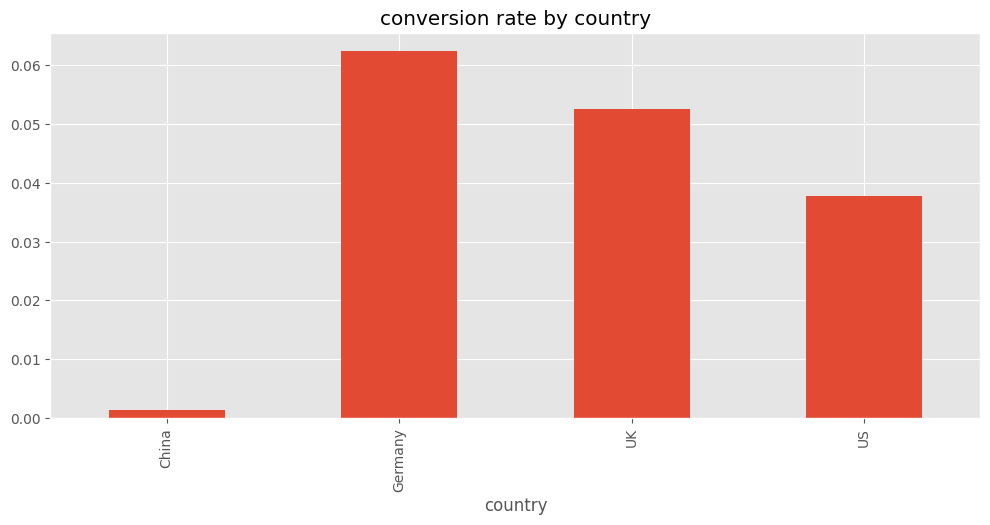

In [14]:
data_country=df.groupby('country').converted.mean(numeric_only=True)
data_country.plot(title='conversion rate by country',kind='bar',figsize=(12,5))

<Axes: title={'center': 'conversion rate by source'}, xlabel='source'>

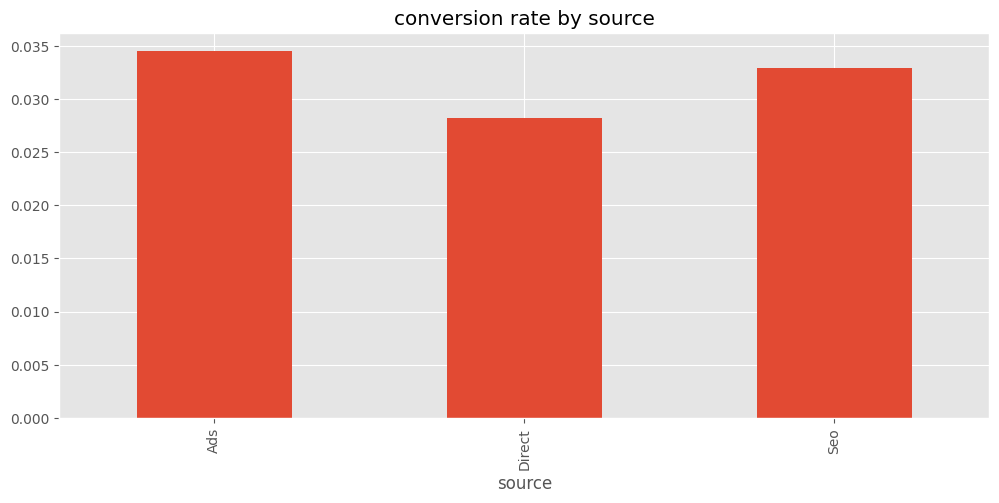

In [15]:
data_source=df.groupby('source').converted.mean(numeric_only=True)
data_source.plot(title='conversion rate by source',kind='bar',figsize=(12,5))

<Axes: title={'center': 'conversion rate by user status'}, xlabel='new_user'>

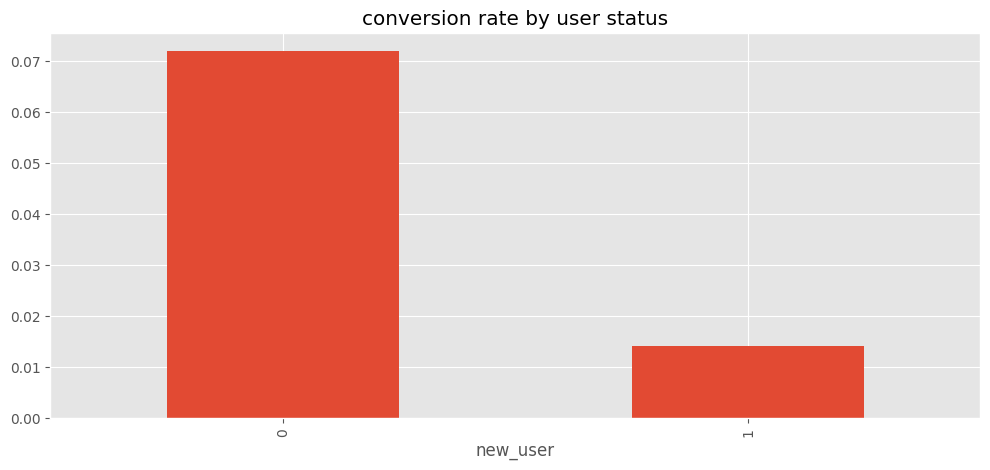

In [16]:
data_new_user=df.groupby('new_user').converted.mean(numeric_only=True)
data_new_user.plot(title='conversion rate by user status',kind='bar',figsize=(12,5))

<Axes: title={'center': 'conversion rate by pages visted'}, xlabel='total_pages_visited'>

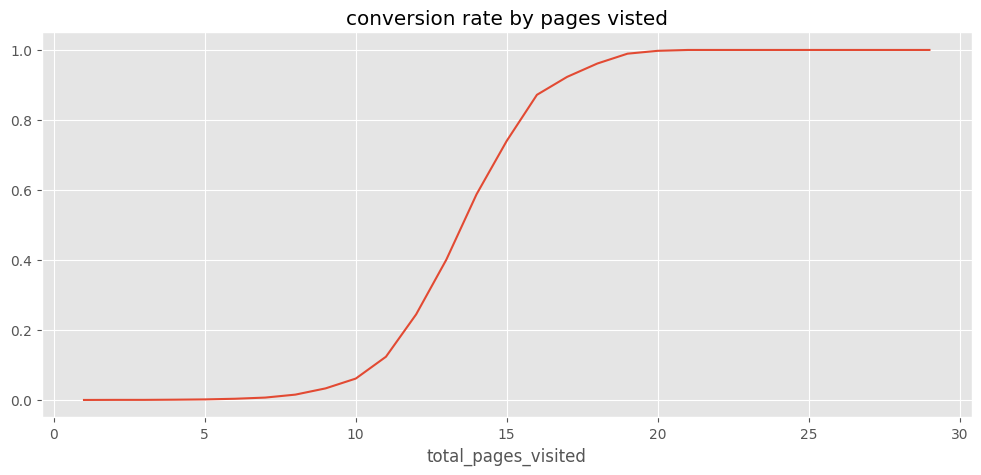

In [17]:
data_pages=df.groupby('total_pages_visited').converted.mean(numeric_only=True)
data_pages.plot(title='conversion rate by pages visted', figsize=(12,5))

## 3. Brief Summary
From data visualization, a few points are clear:
1. Younger is richer, as they are more willing to spend online
2. Chinese users are picky, as conversion rates in China is extremely low
3. People do reseaches before purchase, as conversion rates are positively related to pages visited
4. Ad source doesn't play a big role impacting conversion rates.

At this point I'm ready to go ahead and pre-process data for modeling.

## 4. Data preparation

### a) create dummy variable by one-hot encoding for train and test data

In [18]:
# create dummy variable to prepare model vector
country_index=pd.get_dummies(df.country,dtype=int,prefix='country')
source_index=pd.get_dummies(df.source,dtype=int,prefix='source')
X=pd.concat([df.age,df.new_user,df.total_pages_visited,source_index,country_index],axis='columns')
X

,age,new_user,total_pages_visited,source_Ads,source_Direct,source_Seo,country_China,country_Germany,country_UK,country_US
0,25,1,1,1,0,0,0,0,1,0
1,23,1,5,0,0,1,0,0,0,1
2,28,1,4,0,0,1,0,0,0,1
3,39,1,5,0,0,1,1,0,0,0
4,30,1,6,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
316195,26,1,9,1,0,0,0,0,0,1
316196,27,1,6,0,1,0,0,0,0,1
316197,25,0,4,1,0,0,1,0,0,0
316198,22,0,4,0,0,1,0,0,0,1


In [19]:
Y=pd.DataFrame(df.converted)
Y

,converted
0,0
1,0
2,0
3,0
4,0
...,...
316195,0
316196,0
316197,0
316198,0


### b) SMOTE method to handle imbalanced dataset
I'll first prepare train and test data on the original dataset, and later prepare another train/test data on SMOTE dataset.

The purpose is to see the difference of resampling imbalanced dataset.

In [20]:
# Original dataset split
from sklearn.model_selection import train_test_split
X_train_0,X_test_0,Y_train_0,Y_test_0=train_test_split(X,Y,stratify=Y)
# stratify=Y helps eliminating the possibility of randomly choosing data which are not converted at all
# This is likely to happen when dealing with imbalanced dataset

In [21]:
Y_train_0.value_counts()

converted
0            229500
1              7648
Name: count, dtype: int64

Converted users are extremely low in original dataset, which will have a huge impact on the model to train later on.

In order to reduce the imbalance, I'll go ahead and use SMOTE method to generate synthetic minority samples into the dataset.

In [22]:
from imblearn.over_sampling import SMOTE

Synthetic sample quality is sensitive to the value of k_neighbor. Here I've fine-tuned this to 100 and found this is a good value that returns a good result in model training.

In [23]:
smote=SMOTE(k_neighbors=100) 
X_sm,Y_sm=smote.fit_resample(X,Y)

In [24]:
Y_sm.value_counts()

converted
0            306000
1            306000
Name: count, dtype: int64

In [25]:
X_train_smote,X_test_smote,Y_train_smote,Y_test_smote=train_test_split(X_sm,Y_sm,stratify=Y_sm)

In [26]:
X_train_smote

,age,new_user,total_pages_visited,source_Ads,source_Direct,source_Seo,country_China,country_Germany,country_UK,country_US
272755,25,1,3,1,0,0,1,0,0,0
368336,27,1,18,0,0,0,0,0,0,1
561087,32,0,9,0,0,0,0,0,0,1
509962,29,0,21,0,0,0,0,0,0,0
75741,32,1,7,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
567372,30,0,24,0,0,0,0,0,0,1
198138,31,1,6,0,0,1,0,0,0,1
343321,17,0,20,0,1,0,0,0,0,0
419142,27,0,12,1,0,0,0,0,0,0


In [27]:
Y_train_smote

,converted
272755,0
368336,1
561087,1
509962,1
75741,0
...,...
567372,1
198138,0
343321,1
419142,1


In [28]:
Y_train_smote.value_counts()

converted
0            229500
1            229500
Name: count, dtype: int64

Now that the data is prepped, life is perfectly balanced now and I'm ready to train the machine.

Since this is a binary classification problem, I'll use logistic regression and random forest to train.

## 5. Logistic Regression
Here I'll train two linear regression models. One model will be trained on original dataset (un-SMOTE'd) and the other model will be trained on SMOTE'd dataset.

In [29]:
from sklearn.linear_model import LogisticRegression
lg_0=LogisticRegression(max_iter=len(X_train_smote),solver='newton-cholesky')
lg_smote=LogisticRegression(max_iter=len(X_train_smote),solver='newton-cholesky')

### a) model fitting

In [30]:
lg_0.fit(X_train_0.values,Y_train_0.values.ravel())

LogisticRegression(max_iter=459000, solver='newton-cholesky')

In [31]:
lg_smote.fit(X_train_smote.values,Y_train_smote.values.ravel())

LogisticRegression(max_iter=459000, solver='newton-cholesky')

### b) model evaluation

In [32]:
# model evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
Y_pred_0=lg_0.predict(X_test_0.values)
Y_pred_smote=lg_smote.predict(X_test_0.values)

Here are the classification reports on both models:

In [33]:
# classification report for the first model
print(classification_report(Y_test_0,Y_pred_0))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76500
           1       0.85      0.69      0.76      2550

    accuracy                           0.99     79050
   macro avg       0.92      0.84      0.88     79050
weighted avg       0.99      0.99      0.99     79050



In [34]:
confusion_matrix(Y_test_0,Y_pred_0)

array([[76189,   311],
       [  785,  1765]], dtype=int64)

In [35]:
# classification report for the second, SMOTE'd model
print(classification_report(Y_test_0,Y_pred_smote))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     76500
           1       0.51      0.86      0.64      2550

    accuracy                           0.97     79050
   macro avg       0.75      0.92      0.81     79050
weighted avg       0.98      0.97      0.97     79050



In [36]:
confusion_matrix(Y_test_0,Y_pred_smote)

array([[74366,  2134],
       [  351,  2199]], dtype=int64)

From classification reports and confusion matrices, it's clear to say the recall is significantly improved with SMOTE method. And for us who are looking to start a campaign, model with higher recall is exactly what we want.

Let's see how are these two models performing by plotting PR Curve.

In [37]:
# Precision-Recall Curve
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

Text(0.5, 1.0, 'Precision-Recall curve comparison for Logistic Regression model')

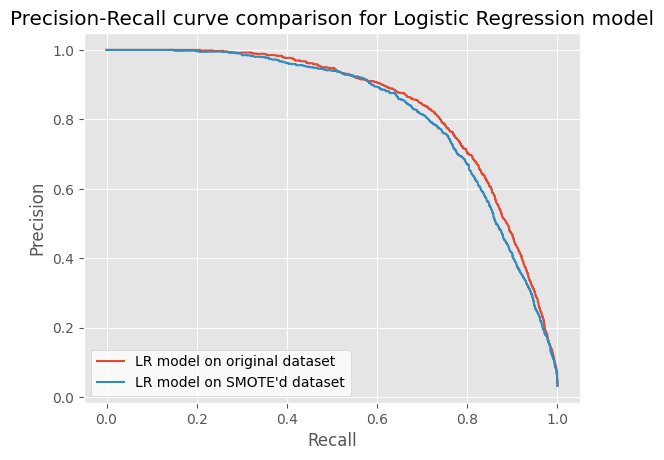

In [38]:
Y_prob_train_0=lg_0.predict_proba(X_test_0.values)[:,1]
precision_0,recall_0,thresholds_0=precision_recall_curve(Y_test_0,Y_prob_train_0)

Y_prob_train_smote=lg_smote.predict_proba(X_test_0.values)[:,1]
precision_smote,recall_smote,thresholds_smote=precision_recall_curve(Y_test_0,Y_prob_train_smote)

plt.plot(recall_0,precision_0)
plt.plot(recall_smote,precision_smote)
plt.legend(["LR model on original dataset", "LR model on SMOTE'd dataset"], loc ="lower left",facecolor='white') 
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve comparison for Logistic Regression model")

It's clear that the model on original dataset is significantly impacted by the imbalanced dataset. Because the goal is to find the very handful amount of converted users from a largely imbalanced dataset, SMOTE method works very well to improve with this issue.

Even though on PR curve the SMOTE'd model performs worse, I'd still use the SMOTE'd model later on, just because the much better true positive rates.

In [39]:
lg=lg_smote

### c) feature importance

In [40]:
coefs = lg.coef_[0]
coefs

array([ -0.10049001,  -2.88476083,   0.82921651,  -8.5897251 ,
        -9.08452301,  -8.17538289, -13.00978023,  -8.27090753,
        -7.65391153,  -7.33099547])

In [41]:
# Here I'm pulling out a feature importance chart to see if data supports my previous summary
feature_importance=pd.DataFrame({'Feature':X_train_smote.columns,'Importance':coefs})
feature_importance.sort_values(by='Importance',ascending=False)

,Feature,Importance
2,total_pages_visited,0.829217
0,age,-0.100490
1,new_user,-2.884761
9,country_US,-7.330995
8,country_UK,-7.653912
5,source_Seo,-8.175383
7,country_Germany,-8.270908
3,source_Ads,-8.589725
4,source_Direct,-9.084523
6,country_China,-13.009780


From the feature importance chart, I can safely summarize a few takeaways here:
1. German and British users are great potential audience, as they obtain the highest conversion rates
2. Users from an ad are more likely to purchase
3. Existing users are generally more willing to purchase than new users
4. Younger is richer

I would go ahead and try to fit a random forest model to see if I can get better results.

## 6. Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()

### a) model fitting

In [43]:
rf.fit(X_train_smote.values,Y_train_smote.values.ravel())

RandomForestClassifier()

### b) model evaluation
Again I'll use the entire dataset as test data.

In [44]:
Y_pred2=rf.predict(X_test_0.values)

In [45]:
# classification report
print(classification_report(Y_test_0,Y_pred2))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     76500
           1       0.54      0.89      0.67      2550

    accuracy                           0.97     79050
   macro avg       0.77      0.93      0.83     79050
weighted avg       0.98      0.97      0.97     79050



In [46]:
# confusion matrix
confusion_matrix(Y_test_0,Y_pred2)

array([[74535,  1965],
       [  287,  2263]], dtype=int64)

Random Forest model has a slightly higher true positive rates than logistic regression.

Text(0.5, 1.0, 'Precision-Recall curve for Random Forest model')

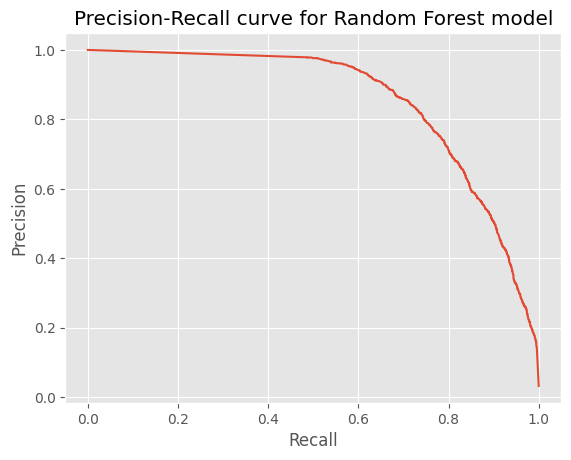

In [47]:
# Precision-Recall Curve
Y_prob_test2=rf.predict_proba(X_test_0.values)[:,1]
precision2,recall2,thresholds2=precision_recall_curve(Y_test_0,Y_prob_test2)
plt.plot(recall2,precision2)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve for Random Forest model")

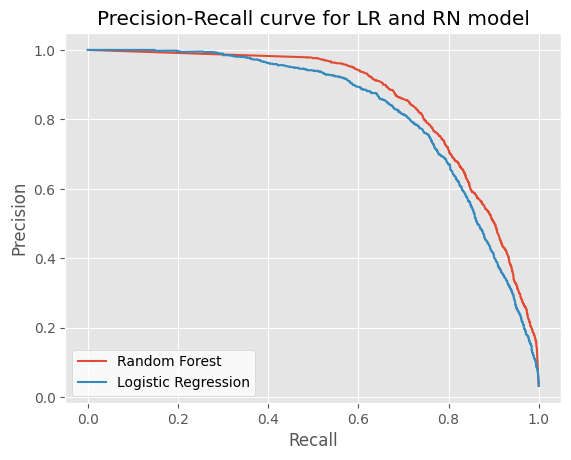

In [48]:
plt.plot(recall2,precision2)
plt.plot(recall_smote,precision_smote)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve for LR and RN model")
plt.legend(["Random Forest", "Logistic Regression"], loc ="lower left",facecolor='white') 

From PR curve, it's safe to say Random Forest model works slightly better than Logistic Regression model. However the recall is slightly worse than logisitic regression model.

### c) Feature Importance

In [49]:
feature_importance=pd.DataFrame({'Feature':X_train_smote.columns,'Importance':rf.feature_importances_})
feature_importance.sort_values(by='Importance',ascending=False)

,Feature,Importance
2,total_pages_visited,0.617082
1,new_user,0.187843
6,country_China,0.067147
0,age,0.036476
4,source_Direct,0.021611
5,source_Seo,0.020376
3,source_Ads,0.019185
9,country_US,0.011186
8,country_UK,0.011154
7,country_Germany,0.007940


In random forest model, total pages visited plays a significant role. This makes sense since people are likely to do researches if they are seriously going to buy something.

Also just imagine how many pages you'll have to go through before ordering anything online. That would also take into account.

## 7. Potential Problem, conclusion and suggestions

### a) Potential Problems

Handling imbalanced dataset with SMOTE method might create instances in noisy and overlapping area, which can generate samples that are not representative of the minority class. In order to minimize this, I used a large number of k neighbors to improve the synthetic samples.

SMOTE'd models are less precise to detect true negative samples. However, it works far better in detecting true positive samples than original models.

I didn't have a chance to go over how to use Tensorflow or sklearn.neural_network.MLPClassifier(), otherwise I could've plotted the training and validation loss curve to see how epoch impacts the model learning.

### b) Conclusions
1. Younger is richer. Young users are much easier to convert
2. Germany is where you want to start a campaign at, and avoid to start in China
3. The more pages visited, the more likely a user will be converted

### c) Suggestions
1. Target young audience when marketing.
2. Target German and UK users when kicking off any campaign.
3. Please investigate on Chinese users in terms of their low conversion rates. Is it the cultural difference? Or is it the VPN?
4. Please also investigate the older user group. Are they not getting what they look for? Or is it just the user experience is not old-user-friendly?